# TensorPRO (Tensorflow Privacy Remindful Optimization)
## Alessio Proietti IN550 Final Exam

### Abstract:
L' idea di base è capire se un cliente in un determinato contesto socioeconomico contattato dalla banca sottoscriverà o no un deposito. 
Il task è di apprendimento supervisionato, le label sono nella colonna 'y'.

Il dataset https://archive.ics.uci.edu/ml/datasets/Bank+Marketing è stato preliminarmente esplorato.
In una seconda fase è stato standardizzata ogni feature numerica, quelle categoriali sono state codificate con la strategia one hot encoding. 

Il dataset era fortemente sbilanciato, nuove istanze per l' allenamento sono state generate con l' algoritmo ADASYN. In conclusione è stata allenata una rete con ottimizzazione ADAM in modalità differential privacy e si sono confrontate delle metriche con la versione non differential private di ADAM.

### Fase Esplorativa

In [1]:
# importo alcune libraries di cui avrò bisogno fin dall' inizio
import pandas as pd
import numpy as np

# libs per visualizzazione
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alessio-proietti/2021-IN550-EXAM/main/data.csv', sep=';')
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.tail(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


In [4]:
# Con questo posso avere un quadro colonne non numeriche
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [5]:
# Posso estrarre informazioni di base sulle colonne numeriche
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
# Stampo i tipi di tutte le variabili per capire con cosa ho a che fare
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [7]:
# Voglio contare i campi nulli o comunque capire se ce ne sono
print(df.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


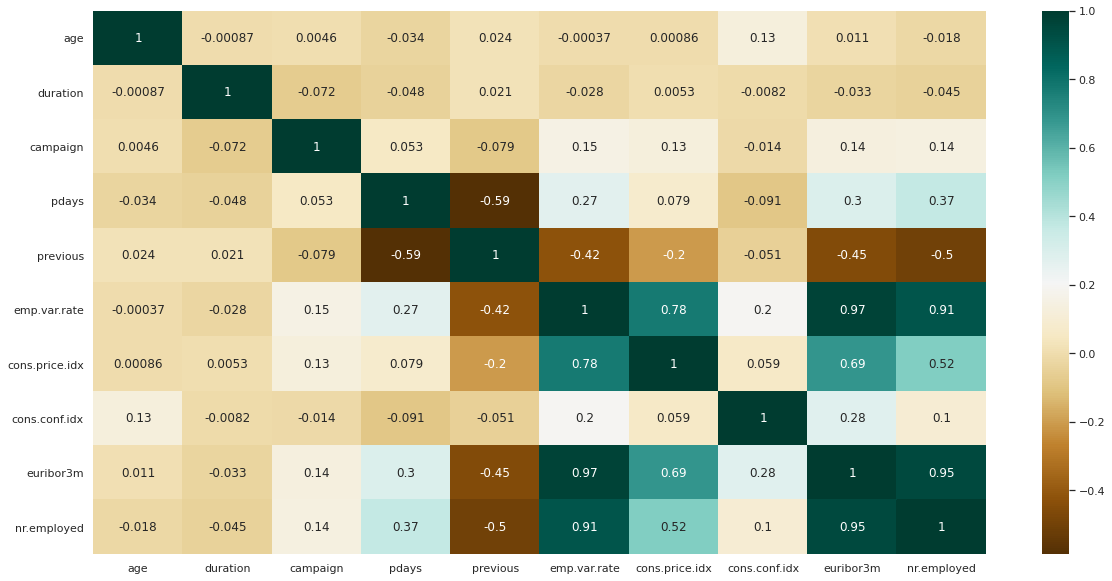

In [8]:
# È interessante calcolare e avere una visione delle correlazione tra le variabili numeriche
plt.figure(figsize=(20,10))
c = df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

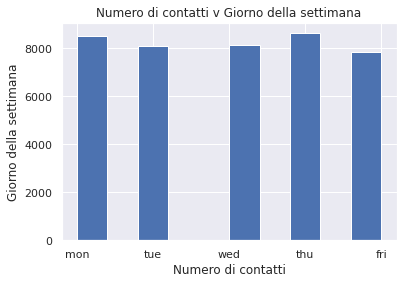

In [9]:
# Voglio vedere se la distribuzione dei contatti sulla settimana è uniforme 
# TL;DR lo è in buona approssimazione

df['day_of_week'].hist().plot(kind="bar", figsize=(10,5))
plt.title("Numero di contatti v Giorno della settimana")
plt.ylabel('Giorno della settimana')
plt.xlabel('Numero di contatti');

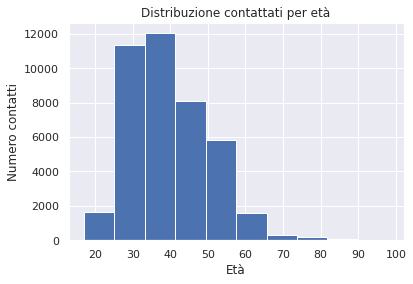

In [10]:
# Come sono distribuiti contattati per età?
df.age.hist().plot(kind="bar", figsize=(10,5))
plt.title("Distribuzione contattati per età")
plt.ylabel('Numero contatti')
plt.xlabel('Età');

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7bdbbb8b0>],
      dtype=object)

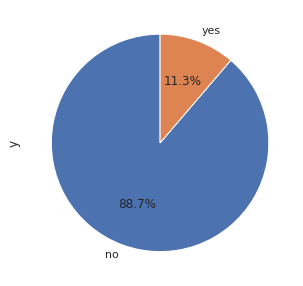

In [11]:
# Il dataset è sbilanciato, ecco un grafico a torta per capire le proporzioni
df.y.value_counts().plot(kind='pie', subplots=True,startangle=90,
figsize=(10,5), autopct='%1.1f%%')

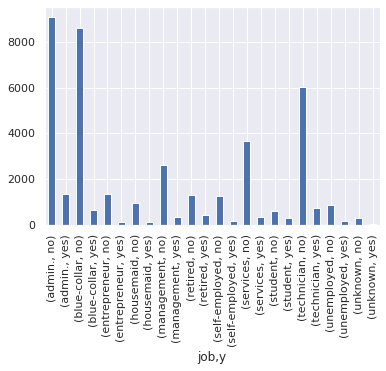

In [12]:
# Voglio vedere come cambia il rapporto YES-NO in base al lavoro
# Non sembra in effetti cambiare

df.groupby('job').y.value_counts().plot(kind='bar')

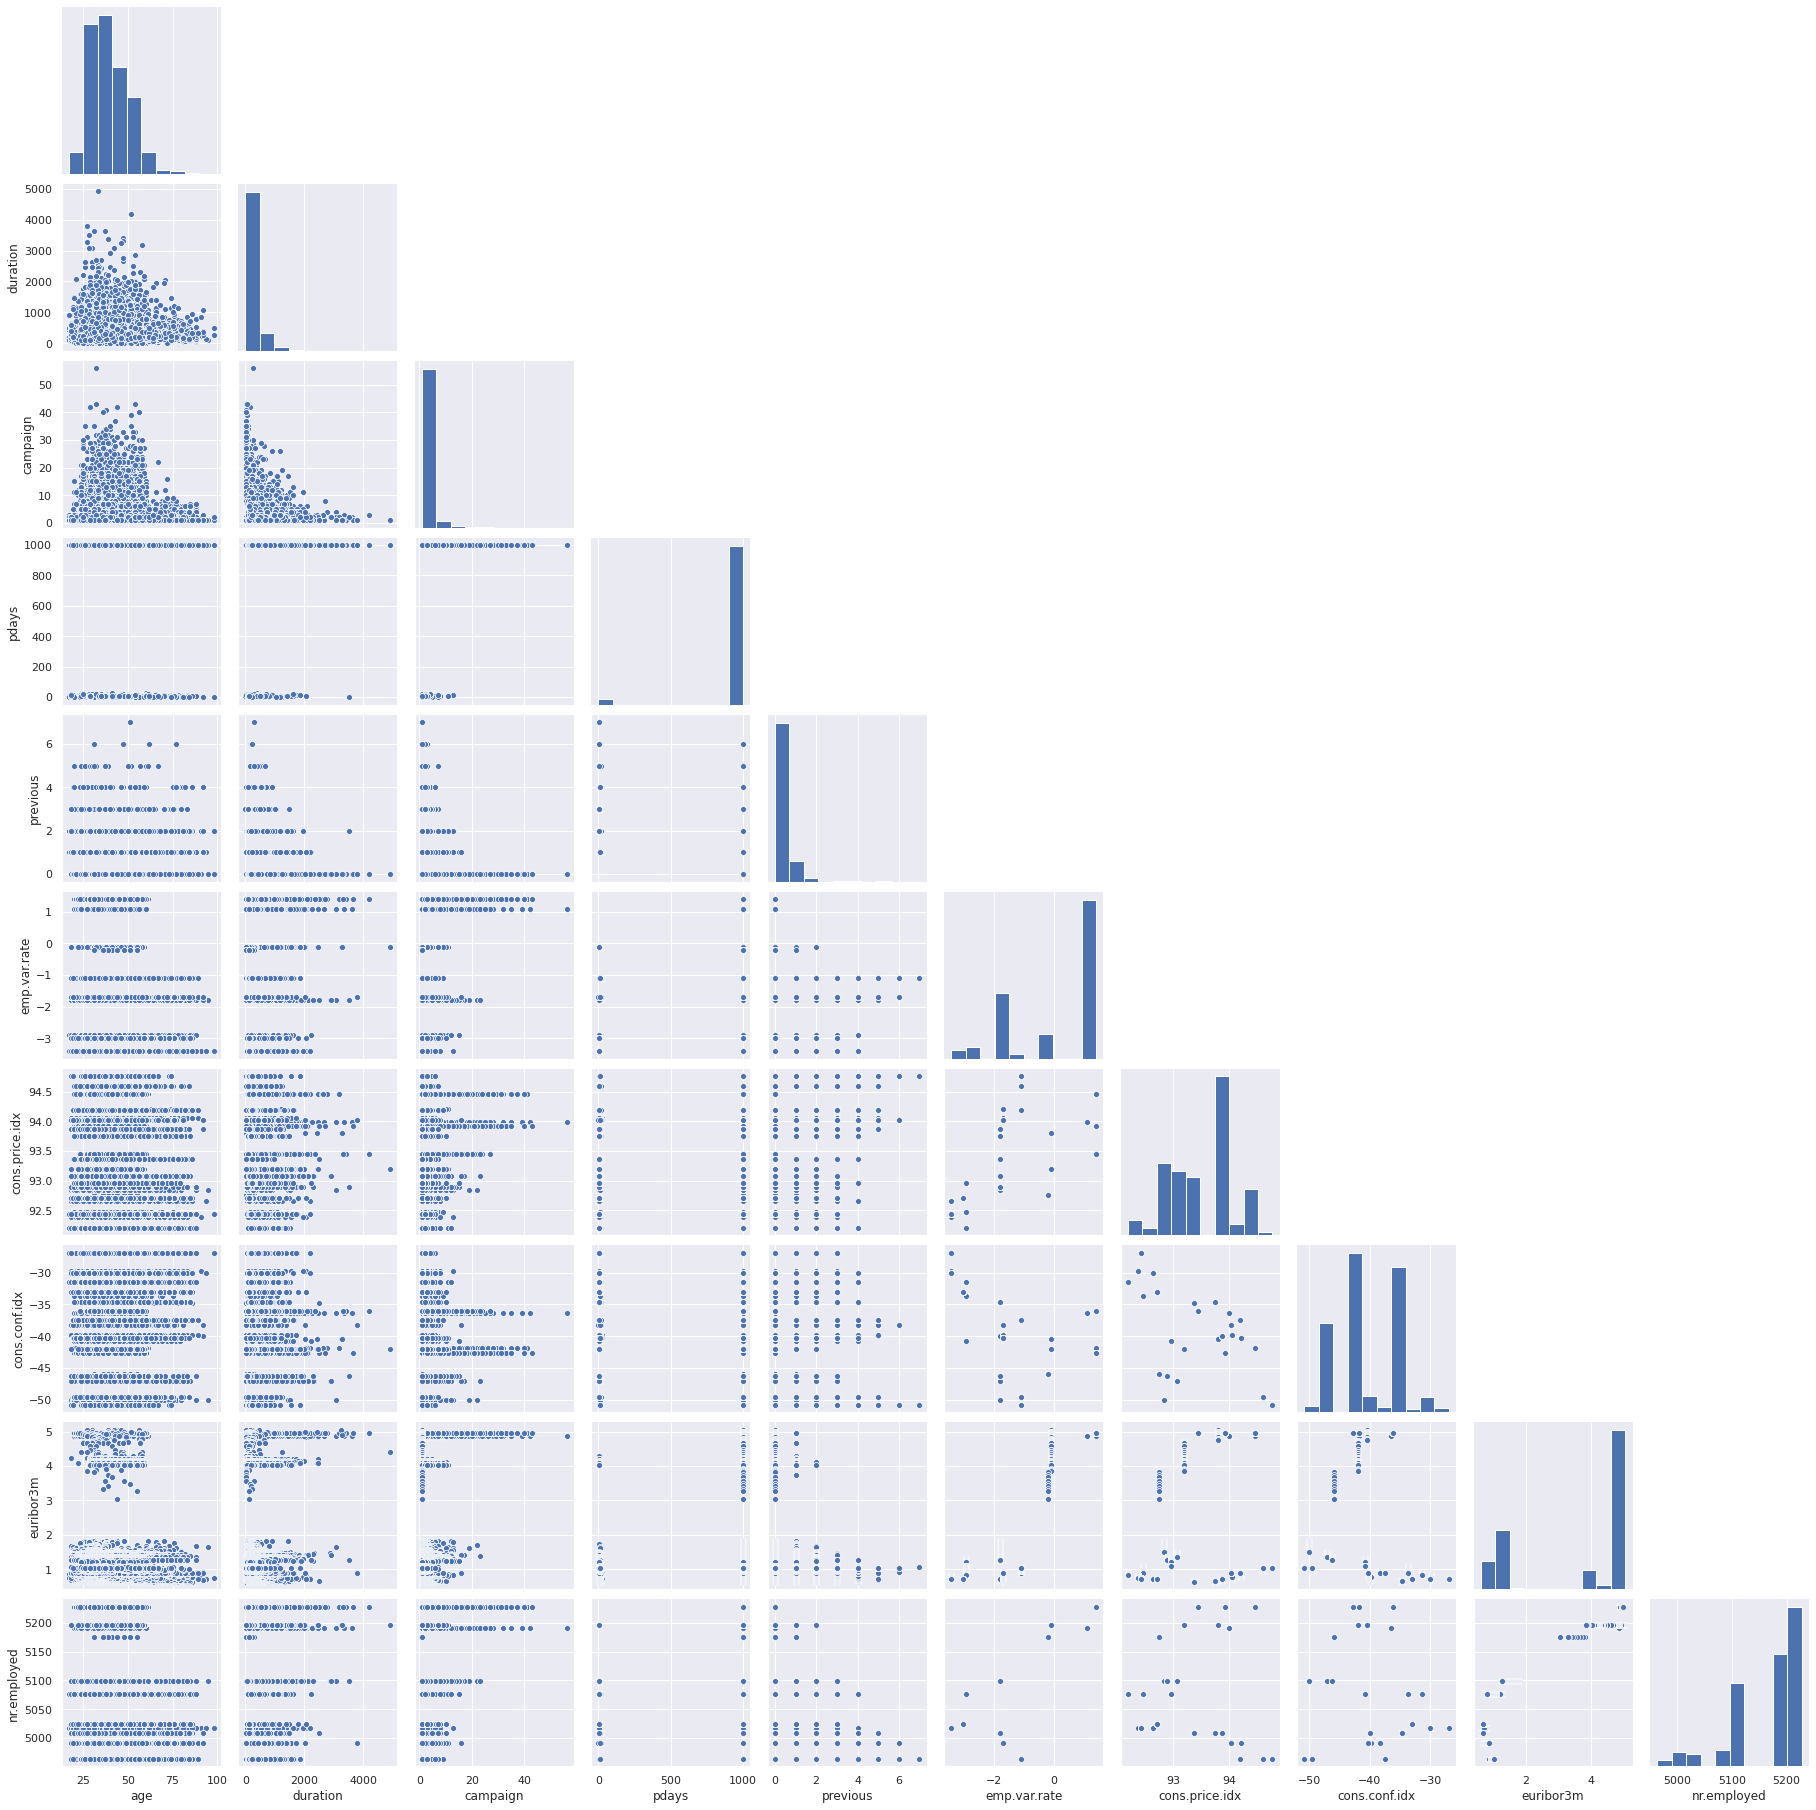

In [13]:
# Stampo scatterplot per le variabili numeriche
gsns=sns.pairplot(df, corner=True)

# non sembrano emergere dei trend

### Preparazione del Dataset

In [14]:
# separo le label dal resto dei dati
labels = df[['y']]
df.drop(columns=['y'])

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6


In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [16]:
# inizializzo gli oggetti che mi permetteranno di codificare le colonne categoriali
le = LabelEncoder()
ohe = OneHotEncoder()

In [17]:
#  estraggo le variabili categoriali e mostro un sample, la testa
categorical = df.select_dtypes(include=[object])
categorical.head(6)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,no
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,no
5,services,married,basic.9y,unknown,no,no,telephone,may,mon,nonexistent,no


In [18]:
# One Hot Encoding delle variabili categoriali
categorical_le = categorical.apply(le.fit_transform)
categorical_sparse = ohe.fit_transform(categorical_le).toarray()

categorical_encoded = pd.DataFrame(categorical_sparse)
categorical_encoded

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
41184,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
41185,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
41186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [19]:
# Estraggo le variabili numeriche
numerical_not_scaled = df.select_dtypes(include=['float64', 'int64'])
numerical_not_scaled

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6


In [20]:
# Per guadagnare performance apporterò una standardizzazione ai dati numerici
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [21]:
numerical_ndarray = scaler.fit_transform(numerical_not_scaled)
numerical = pd.DataFrame(numerical_ndarray)
numerical

,0,1,2,3,4,5,6,7,8,9
0,1.533034,0.010471,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680
1,1.628993,-0.421501,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680
2,-0.290186,-0.124520,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680
3,-0.002309,-0.413787,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680
4,1.533034,0.187888,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680
...,...,...,...,...,...,...,...,...,...,...
41183,3.164336,0.292025,-0.565922,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697
41184,0.573445,0.481012,-0.565922,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697
41185,1.533034,-0.267225,-0.204909,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697
41186,0.381527,0.708569,-0.565922,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697


In [22]:
# Riunisco i dati numerici riscalati con la parte codificata delle variabili categoriali
features=numerical.join(categorical_encoded, lsuffix='_caller', rsuffix='_other')
features

,0_caller,1_caller,2_caller,3_caller,4_caller,5_caller,6_caller,7_caller,8_caller,9_caller,...,45,46,47,48,49,50,51,52,53,54
0,1.533034,0.010471,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.628993,-0.421501,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.290186,-0.124520,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.002309,-0.413787,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.533034,0.187888,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,3.164336,0.292025,-0.565922,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
41184,0.573445,0.481012,-0.565922,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
41185,1.533034,-0.267225,-0.204909,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
41186,0.381527,0.708569,-0.565922,0.195414,-0.349494,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [23]:
# Trasformo il DataFrame in un ndarray
features_array = features.to_numpy()
features_array

array([[ 1.53303429,  0.01047142, -0.56592197, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.62899323, -0.42150051, -0.56592197, ...,  0.        ,
         1.        ,  0.        ],
       [-0.29018564, -0.12451981, -0.56592197, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.53303429, -0.26722482, -0.20490853, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.38152696,  0.70856893, -0.56592197, ...,  0.        ,
         0.        ,  1.        ],
       [ 3.26029527, -0.07438021,  0.15610492, ...,  0.        ,
         1.        ,  0.        ]])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7c2616f40>],
      dtype=object)

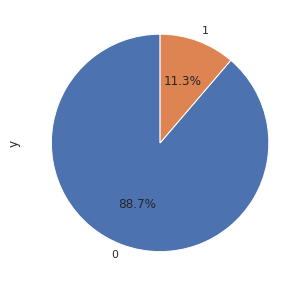

In [24]:
# Riporto di nuovo il grafico a torta per la label questa volta codificate con LinearEncoder
labels_le = labels.apply(le.fit_transform)
labels_le.y.value_counts().plot(kind='pie', subplots=True,startangle=90,
figsize=(10,5), autopct='%1.1f%%')

In [25]:
# Divido il dataset nelle istanze di training e di test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_le, test_size=0.5)

### ADASYN Oversampling

In [26]:
# SOLO sulle istanze di training agirò con un algoritmo di Oversampling, ADASYN
from imblearn.over_sampling import ADASYN
oversample = ADASYN()

In [27]:
# Resample
X_train, y_train = oversample.fit_resample(X_train, y_train)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7ae74a0d0>],
      dtype=object)

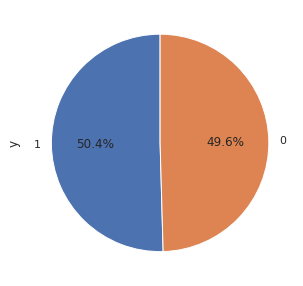

In [28]:
# Come è cambiata la distribuzione?
y_train.y.value_counts().plot(kind='pie', subplots=True,startangle=90,
figsize=(10,5), autopct='%1.1f%%')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7ae7114c0>],
      dtype=object)

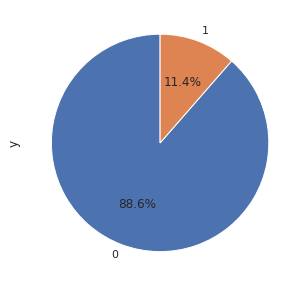

In [29]:
# Sul test set le proporzioni sono quelle originarie...
y_test.y.value_counts().plot(kind='pie', subplots=True,startangle=90,
figsize=(10,5), autopct='%1.1f%%')

In [30]:
# Porto training set e test set in formato ndarray
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
print(type(y_train), type(y_test), type(X_train), type(X_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


### A Machine is Learning ...

In [31]:
# È necessario avere TF >= 2 per utilizzare il pacchetto tensorflow-privacy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
print(tf.__version__)

2.3.1


In [32]:
# Definisco l' architettura dei una rete neurale "profonda" che alleneremo
model = Sequential([
  Dense(20, activation='relu', input_shape=(65,)),
  Dropout(.3),
  Dense(20, activation='relu'),
  Dropout(.3),
  Dense(20, activation='relu'),
  Dropout(.3),
  Dense(20, activation='relu'),
  Dense(1, activation='sigmoid'),
])

In [33]:
# Adam Optimizer con privacy learning
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer
optimizer = DPKerasAdamOptimizer(
    l2_norm_clip=1.5,
    noise_multiplier=1.3,
    num_microbatches=1033,
    learning_rate=0.025)

In [34]:
model.compile(
  optimizer=optimizer,
  loss='binary_crossentropy',
  metrics=['accuracy','Precision', 'Recall']
)

In [35]:
history_dpadam=model.fit(
  X_train, 
  y_train, 
  epochs=10,
  validation_split=0.33,
  batch_size=24,
)

Epoch 1/10
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0551 - accuracy: 0.9879 - precision: 0.9802 - recall: 0.9733 - val_loss: 0.0365 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/10
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0072 - accuracy: 0.9983 - precision: 0.9957 - recall: 0.9978 - val_loss: 5.6394e-07 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
1032/1032 [==============================] - 1s 1ms/step - loss: 0.0053 - accuracy: 0.9993 - precision: 0.9978 - recall: 0.9994 - val_loss: 1.2570e-19 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0441 - accuracy: 0.9946 - precision: 0.9827 - recall: 0.9967 - val_loss: 9.2122e-07 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0077 -

In [36]:
print("Valuto il modello sui dati di test")
results = model.evaluate(X_test, y_test, batch_size=48)
print("test loss, test acc:", results)


print("Genero 10 predizioni")
predictions = model.predict(X_test[:10])
print("predizioni: \n", predictions)
y_test[:10]

Valuto il modello sui dati di test
430/430 [==============================] - 0s 848us/step - loss: 6.7398e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 0.9996
test loss, test acc: [6.739788659615442e-05, 0.9999514222145081, 1.0, 0.9995748400688171]
Genero 10 predizioni
predizioni: 
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

Sui dati di test il modello raggiunge accuracy, precision, recall 1.
È incoraggiante ma apre domande sulla correttezza metodologica della ricerca.

In [37]:
# Adam Optimizer con privacy learning
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy','Precision', 'Recall']
)

In [38]:
history_adam = model.fit(
  X_train, 
  y_train, 
  epochs=10,
  validation_split=0.33,
  batch_size=24,
)

Epoch 1/10
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0025 - accuracy: 0.9996 - precision: 0.9986 - recall: 0.9998 - val_loss: 2.4585e-13 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/10
1032/1032 [==============================] - 2s 1ms/step - loss: 0.0039 - accuracy: 0.9993 - precision: 0.9974 - recall: 1.0000 - val_loss: 5.5247e-19 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0046 - accuracy: 0.9990 - precision: 0.9964 - recall: 0.9998 - val_loss: 8.0681e-24 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
1032/1032 [==============================] - 2s 1ms/step - loss: 0.0024 - accuracy: 0.9995 - precision: 0.9983 - recall: 0.9997 - val_loss: 1.8211e-30 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
1032/1032 [==============================] - 2s 1ms/step - loss: 0.00

In [39]:
print("Valuto il modello sui dati di test")
results = model.evaluate(X_test, y_test, batch_size=48)
print("test loss, test acc:", results)


print("Genero 10 predizioni")
predictions = model.predict(X_test[:10])
print("predizioni: \n", predictions)
y_test[:10]

Valuto il modello sui dati di test
430/430 [==============================] - 0s 810us/step - loss: 1.8675e-32 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
test loss, test acc: [1.8674947977767153e-32, 1.0, 1.0, 1.0]
Genero 10 predizioni
predizioni: 
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

### Conclusioni

Si sarebbe potuto ipotizzare che usare usare una versione di ADAM dove SGD è sostituito da DP-SGD potesse impattarne le performance, almeno nel caso in esame ciò non sembra vero.

Riporto il sommario di tutti gli eventi nel training dei due modelli

In [40]:
history_dpadam.history

{'loss': [0.05509936437010765,
  0.007211335003376007,
  0.0053247311152517796,
  0.04408570006489754,
  0.007658937945961952,
  0.008916027843952179,
  0.020335813984274864,
  0.013938344083726406,
  0.013408748432993889,
  0.004151897504925728],
 'accuracy': [0.9879196882247925,
  0.9983031153678894,
  0.9992727637290955,
  0.9945860505104065,
  0.9989899396896362,
  0.9982627034187317,
  0.9976970553398132,
  0.9979394674301147,
  0.9980607032775879,
  0.9991111755371094],
 'precision': [0.9801562428474426,
  0.9956649541854858,
  0.9978311657905579,
  0.9827137589454651,
  0.9969040155410767,
  0.9941340088844299,
  0.9929012060165405,
  0.9932119846343994,
  0.9944350123405457,
  0.997829794883728],
 'recall': [0.9733126163482666,
  0.9978277683258057,
  0.9993793368339539,
  0.9967416524887085,
  0.9992241859436035,
  0.9992241859436035,
  0.9982932209968567,
  0.9989138841629028,
  0.9981380701065063,
  0.9987587332725525],
 'val_loss': [0.03654821217060089,
  5.6393838576696e-0

In [41]:
history_adam.history

{'loss': [0.0024528377689421177,
  0.003883347613736987,
  0.004555525258183479,
  0.00239232974126935,
  0.002603180706501007,
  0.003047616919502616,
  0.0030776720959693193,
  0.0036142594181001186,
  0.0033086712937802076,
  0.0023943744599819183],
 'accuracy': [0.9995959997177124,
  0.9993131756782532,
  0.999030351638794,
  0.9994747638702393,
  0.9995959997177124,
  0.9993131756782532,
  0.9993131756782532,
  0.9995959997177124,
  0.9993131756782532,
  0.9994747638702393],
 'precision': [0.9986053109169006,
  0.9973692297935486,
  0.996443510055542,
  0.9982956051826477,
  0.9986053109169006,
  0.9975232481956482,
  0.9975232481956482,
  0.9986053109169006,
  0.9973692297935486,
  0.9979869723320007],
 'recall': [0.9998448491096497,
  1.0,
  0.9998448491096497,
  0.9996896982192993,
  0.9998448491096497,
  0.9998448491096497,
  0.9998448491096497,
  0.9998448491096497,
  1.0,
  1.0],
 'val_loss': [2.4585064886673003e-13,
  5.524679340647262e-19,
  8.068134861576695e-24,
  1.8211